---
title: Introduction to image processing
subtitle: M1 Informatique - Nantes Université
license: CC-BY-4.0
authors:
  - name: Matthieu Perreira Da Silva
    affiliations: Nantes Université
    email: matthieu.perreiradasilva@univ-nantes.fr
  - name: Vincent Ricordel
    affiliations: Nantes Université
    email: vincent.recordel@univ-nantes.fr
---
```{image} ../standard_test_images/lena_gray_256.png
:alt: Lena
:width: 256px
```
```{image} ../standard_test_images/cameraman.png
:alt: Cameraman
:width: 256px
```
```{image} ../standard_test_images/peppers_gray.png
:alt: Peppers
:width: 256px
```
```{image} ../standard_test_images/livingroom.png
:alt: Livigroom
:width: 256px
```

In [1]:
%pip install -q scikit-image opencv-python ipywidgets==8.1.1 matplotlib ipympl


[notice] A new release of pip is available: 23.3.1 -> 24.0
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [2]:
import cv2
import numpy as np
from matplotlib import pyplot as plt
from skimage import io, util, filters, color
import ipywidgets as widgets
from ipywidgets import interact
from matplotlib.colors import LinearSegmentedColormap

plt.rcParams['figure.figsize']=[8,6]

# Colors and color spaces
```{image} Images/RGB-Lab.jpeg
:alt: We need to add an illustration
:width: 800px
```

## Visible light

- Visible light is only one (small) fraction of all electromagnetic waves
```{image} Images/Visible-spectrum.webp
:alt: Visible light in the full waves spectrum
:width: 800px
```

## Human L,M,S cones light adsorption
```{figure} Images/Cones-spectrum.svg
:alt: LMS cones adsorption
:width: 500px
:class: float-right
```
- Each type of cone responds to a specific range of wavelengths
    - Short (S, 445nm) : to blue
    - Medium (M, 535nm) : to green
    - Long (L, 575nm) : to red
- We are more sensitive to green than red and blue
- Colorblindness is a deficiency in at least one type of cone

## Color perception
```{figure} Images/Metamers.jpeg
:alt: Metamer colors
:width: 500px
:class: float-right
```
- The color of an object is the results of the interaction between
    - The light source
    - The physical properties of the object
- This leads to an emitted power spectrum
    - Integrated into 3 'value' by the L,M and S cones
- 3 values do cannot fully represent a full spectrum
    - Ambiguities = color metamerism

## CIE RGB color space
```{figure} Images/CIE1931_RGBCMF2.png
:alt: RGB color matching functions
:width: 500px
:class: float-right
```
- Additive color model, used for displays
- Created in 1931 !
- Inspired by human L,M,S cone cells
    - Does not mimic human visual system, LMS color space does
- Based on standard monochromatic primaries
    - 700 nm (red)
    - 546.1 nm (green)
    - 435.8 nm (blue)
- There are [many RGB color spaces](https://en.wikipedia.org/wiki/RGB_color_spaces) (ex: sRGB, Adobe RGB, DCI-P3, etc.)
    - Depends on how colors are produced

```{figure} Images/CMYK_color_model.png
:alt: CMYK color space
:width: 300px
:class: float-right
```
## CMY color space
- Subtracting color model, used for printing
    - Ink reduces the light that would otherwise be reflected.
- White is the reference color (instead of black)   
- CMYK exists also because in practice $C+M+Y \neq K$ (black) 
- RGB and CMY(K) don't have the same color gamut
    - Gamut = set of reproducible colors
    

## CIE XYZ color space
```{figure} Images/SRGB_chromaticity.png
:alt: sRGB colors in x,y CIE chromaticity diagram 
:width: 300px
:class: float-right
sRGB color space in x,y plane
```
- Device independent color space derived from RGB
- Encompasses all color sensations that are visible to a person with average eyesight
- Serves as a standard reference for the other color spaces
    - Y is the luminance
    - Z is quasi-equal to blue (of CIE RGB)
    - X is a mix of the three CIE RGB curves chosen to be non-negative
- $xyz$ is the relative color space associated with XYZ
    - $x=\frac{X}{X+Y+Z} \quad y=\frac{Y}{X+Y+Z} \quad z=\frac{Z}{X+Y+Z}$

## HSI / HSL / HSV color spaces
```{figure} Images/Hsl-hsv_models.png
:alt: HSL / HSV models 
:width: 300px
:class: float-right
```
- Not related to human perception (LMS or RGB decomposition)
- Provide a practical way of selecting colors
    - Hue = color tint
    - Saturation = intensity of color (0 is gray)
    - Intensity / Lightness / Value = different way of expressing brightness
- Built from (non linear) geometric transforms of RGB space]
    - More details [here](https://en.wikipedia.org/wiki/HSL_and_HSV)


## YIQ / YUV / YCrCb color spaces
```{figure} Images/YUV_UV_plane.png
:alt: YUV UV plane 
:width: 400px
:class: float-right
```
- Device dependent color models used for TV
- Y is the luma / brightness component
    - $Y = 0,299⋅R + 0,587⋅G + 0,114⋅B$
    - Only channel used for B&W TV
- Other components encode color at constant brightness
- Example for YUV
    - $U \approx 0.492(B-Y)$
    - $V \approx 0.877(R-Y)$

## CIE Lab color space

- Device independent color space, built to be **perceptually uniform**
    - Intended to mimic the nonlinear response of the visual system
```{figure} Images/Lab-color-space.jpg
:alt: YUV UV plane 
:width: 600px
:class: float-right
```
- Lightness 
    - $L = 116f(Y/Y_n)-16$
- Green / red opponent colors channel 
    - $a = 500(f(X/X_n)-f(Y/Y_n))$
- Blue / yellow opponent colors channel
    - $b = 200(f(Y/Y_n)-f(Z/Z_n))$
- with $f(t)=\sqrt[3]{t}$ (most of the time) and $X_n, Y_n, Z_n$ the color coordinates of a standard illuminant (ex:D65)

## Color distances

- Can be calculated using any distance (ex: L1 or L2)
    $$L_k\left(p,q\right) = \sqrt[k]{\sum _{i=1}^{n}  \left( q_{i}-p_{i}\right)^k}$$
-  CIE76 $\Delta E_{pq}$ is a simple euclidean L2 distance 
- To be perceptually uniform need to be applied on a **perceptually uniform color space** (ex: CIE Lab)
- CIE94 and CIE2000 $\Delta E$ correct CIE76 $\Delta E$ to make it more perceptually uniform
    - No more a simple euclidean distance !
- $\Delta E_{pq}\approx 2.3$ corresponds to a JND (just noticeable difference)

## 3D color histogram of an image

- Here we use a 8x8x8=512 bins histogram
    - A 256x256x256 histogram whould occupy 16Mb of memory...
 

In [3]:

# This function is just here to isolate the variables and figures for this example
def example_3D_hist():
    def histogram3dplot(h, e, elev=45, azim=45, fig=None):
        """
        Visualize a 3D histogram

        Parameters
        ----------

        h: histogram array of shape (M,N,O)
        e: list of bin edge arrays (for R, G and B)

        Code adapted from : https://staff.fnwi.uva.nl/r.vandenboomgaard/IPCV20172018/LectureNotes/IP/Images/ImageHistograms.html
        """
        M, N, O = h.shape
        idxR = np.arange(M)
        idxG = np.arange(N)
        idxB = np.arange(O)

        R, G, B = np.meshgrid(idxR, idxG, idxB)
        a = np.diff(e[0])[0]
        b = a/2
        R = a * R + b

        a = np.diff(e[1])[0]
        b = a/2
        G = a * G + b

        a = np.diff(e[2])[0]
        b = a/2
        B = a * B + b

        colors = np.vstack((G.flatten(), R.flatten(), B.flatten())).T/255
        h = h / np.sum(h)
        if fig is not None:
            f = plt.figure(fig)
        else:
            f = plt.gcf()
        ax = f.add_subplot(122, projection='3d')   
        ax.set_title('3D color histogram')
        mxbins = np.array([M,N,O]).max()
        ax.view_init(elev=elev, azim=azim)
        ax.scatter(G.flatten(), R.flatten(), B.flatten(), s=h.flatten()*(256/mxbins)**3/2, c=colors)

        ax.set_xlabel('Red')
        ax.set_ylabel('Green')
        ax.set_zlabel('Blue')

    @interact( elev = widgets.IntSlider( value=45, min=0, max=360, step=1, continuous_update=True ),
                azim = widgets.IntSlider( value=45, min=0, max=360, step=1, continuous_update=True ))
    def show3D_hist(elev, azim):
        image=io.imread('../standard_test_images/mandril_color.png')
        fig = plt.figure()
        fig.set_figwidth(12)
        ax=plt.subplot(1,2, 1)
        ax.set_title('Image')
        ax.imshow(image);
        h, e = np.histogramdd(image.reshape(-1,3), bins=8, range=[(0,255),(0,255),(0,255)])
        histogram3dplot(h, e, elev, azim, fig)
        plt.show()
    
example_3D_hist()

interactive(children=(IntSlider(value=45, description='elev', max=360), IntSlider(value=45, description='azim'…

## Independent R, G and B histograms

- Easier to build and store but carry out less information ☹️

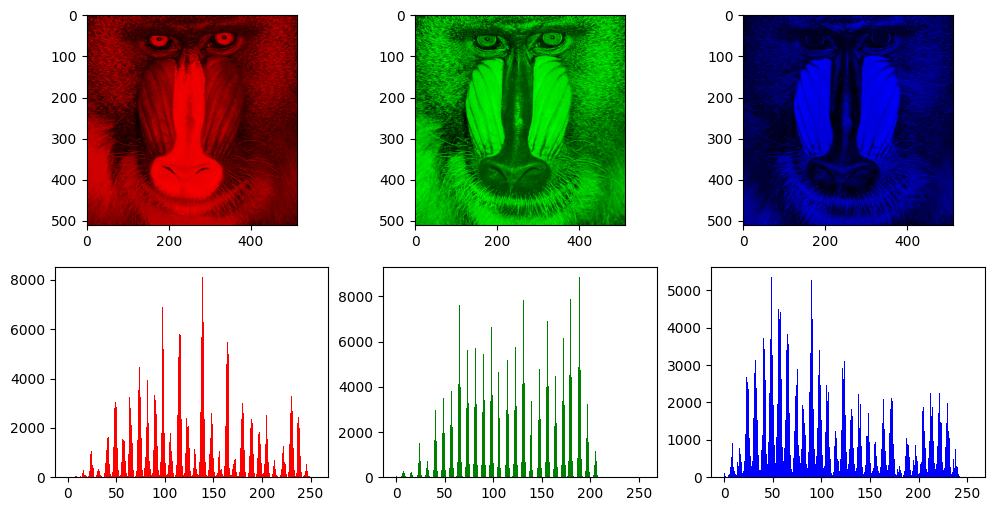

In [4]:

# This function is just here to isolate the variables and figures for this example
def example_3x1D_histo():
    image=io.imread('../standard_test_images/mandril_color.png')
    image_red, image_green, image_blue = image[:,:,0], image[:,:,1], image[:,:,2]

    fig, ax = plt.subplots(2,3)
    fig.set_figwidth(12)
    colors = [(0, 0, 0), (1, 0, 0)]
    redMap = LinearSegmentedColormap.from_list('R',colors)
    ax[0,0].imshow(image_red, cmap=redMap)
    colors = [(0, 0, 0), (0, 1, 0)]
    greenMap = LinearSegmentedColormap.from_list('R',colors)
    ax[0,1].imshow(image_green, cmap=greenMap)
    colors = [(0, 0, 0), (0, 0, 1)]
    blueMap = LinearSegmentedColormap.from_list('R',colors)
    ax[0,2].imshow(image_blue, cmap=blueMap)

    bins = np.arange(-0.5, 255+1,1)
    ax[1,0].hist(image_red.flatten(), bins = bins, color='r');
    ax[1,1].hist(image_green.flatten(), bins = bins, color='g');
    ax[1,2].hist(image_blue.flatten(), bins = bins, color='b');

example_3x1D_histo()

## Basic color image processing principles

- Use a specific color space and take decisions on / process specific channels 
    - Ex: intensity, or hue
- Apply the same operation on all channels independently
- Work with color distances / vector based processing

## Example : color segmentation

- Simple thresholding (which channel(s))
    - 3D histogram vs. 3x 1D histograms for decision taking
- 1D / 2D / 3D clustering
    - K-means

## Thresholding in RGB space

In [5]:

# This function is just here to isolate the variables and figures for this example
def example_rgb_segmentation():
    image=io.imread('../standard_test_images/mandril_color.png')
    
    @interact( R = widgets.IntRangeSlider( value=[0, 255], min=0, max=255, step=1, continuous_update=False ),
                G = widgets.IntRangeSlider( value=[0, 255], min=0, max=255, step=1, continuous_update=False ),
                B = widgets.IntRangeSlider( value=[0, 255], min=0, max=255, step=1, continuous_update=False ))
    def multiThresholdSegmentationRGB( R, G, B ):
        fig = plt.figure()
        fig.set_figwidth(12)
        ax=plt.subplot(1,2, 1)
        ax.set_title('Image')
        ax.imshow(image);
        
        img = image
        bin_img =  ((R[0] <= img[:,:,0]) & (img[:,:,0] <= R[1]) & (G[0] <= img[:,:,1]) & (img[:,:,1] <= G[1]) & (B[0] <= img[:,:,2]) & (img[:,:,2] <= B[1]))*255
        ax = fig.add_subplot(122)   
        ax.set_title('Thresholded image')
        ax.imshow(bin_img, cmap='gray', vmin=0, vmax=255)
        plt.show()
    
example_rgb_segmentation()

interactive(children=(IntRangeSlider(value=(0, 255), continuous_update=False, description='R', max=255), IntRa…

## Thresholding in HSV space

In [6]:

# This function is just here to isolate the variables and figures for this example
def example_hsv_segmentation():
    image=io.imread('../standard_test_images/mandril_color.png')
    
    @interact( H = widgets.FloatRangeSlider( value=[0, 1], min=0, max=1, step=0.01, continuous_update=False ),
                S = widgets.FloatRangeSlider( value=[0, 1], min=0, max=1, step=0.01, continuous_update=False ),
                V = widgets.FloatRangeSlider( value=[0, 1], min=-0, max=1, step=0.01, continuous_update=False ))
    def multiThresholdSegmentation( H, S, V ):
        fig = plt.figure()
        fig.set_figwidth(12)
        ax=plt.subplot(1,2, 1)
        ax.set_title('Image')
        ax.imshow(image);
        
        img = color.rgb2hsv(image)
        bin_img =  ((H[0] <= img[:,:,0]) & (img[:,:,0] <= H[1]) & (S[0] <= img[:,:,1]) & (img[:,:,1] <= S[1]) & (V[0] <= img[:,:,2]) & (img[:,:,2] <= V[1]))*255
        ax = fig.add_subplot(122)   
        ax.set_title('Thresholded image')
        ax.imshow(bin_img, cmap='gray', vmin=0, vmax=255)
        plt.show()
        
example_hsv_segmentation()

interactive(children=(FloatRangeSlider(value=(0.0, 1.0), continuous_update=False, description='H', max=1.0, st…

## Thresholding by RGB color distance 

- Let's a target color and and a distance threshold (we use L2 distance on RGB colors)

In [7]:

# This function is just here to isolate the variables and figures for this example
def example_dist_segmentation_rgb():
    image=io.imread('../standard_test_images/mandril_color.png')
    
    @interact( ref_color = widgets.ColorPicker( concise=False, description='Pick a color', value='#000000', disabled=False ),
                max_distance = widgets.IntSlider( value=70, min=0, max=255, step=1, continuous_update=False ))
    def exampleBasedSegmentationRGB( ref_color, max_distance ):
        fig = plt.figure()
        fig.set_figwidth(12)
        ax=plt.subplot(1,2, 1)
        ax.set_title('Image')
        ax.imshow(image);
        
        img=image
        ref_color=[int(ref_color[1:3],16), int(ref_color[3:5],16), int(ref_color[5:7],16)]
        diff =  img-ref_color
        # Compute the L2 norm of the color difference
        bin_img = (np.sqrt(diff[:,:,0]**2 + diff[:,:,1]**2 + diff[:,:,2]**2) <= max_distance)*255
        ax = fig.add_subplot(122)   
        ax.set_title('Thresholded image')
        ax.imshow(bin_img, cmap='gray', vmin=0, vmax=255)
        plt.show()
        
example_dist_segmentation_rgb()

interactive(children=(ColorPicker(value='#000000', description='Pick a color'), IntSlider(value=70, continuous…

## Thresholding by Lab color distance 

- Here we use L2 distance + CIE Lab color space ($\Delta E$ CIE76)

In [8]:

# This function is just here to isolate the variables and figures for this example
def example_dist_segmentation_lab():
    image=io.imread('../standard_test_images/mandril_color.png')
    
    @interact( ref_color = widgets.ColorPicker( concise=False, description='Pick a color', value='#000000', disabled=False ),
                max_distance = widgets.IntSlider( value=20, min=0, max=100, step=1, continuous_update=False ))
    def exampleBasedSegmentationLab( ref_color, max_distance ):
        fig = plt.figure()
        fig.set_figwidth(12)
        ax=plt.subplot(1,2, 1)
        ax.set_title('Image')
        ax.imshow(image);
        
        img=color.rgb2lab(image)
        ref_color=[int(ref_color[1:3],16)/255, int(ref_color[3:5],16)/255, int(ref_color[5:7],16)/255]
        ref_color=color.rgb2lab(ref_color)
        diff =  img-ref_color
        # Compute the L2 norm of the color difference
        bin_img = (np.sqrt(diff[:,:,0]**2 + diff[:,:,1]**2 + diff[:,:,2]**2) <= max_distance)*255
        ax = fig.add_subplot(122)   
        ax.set_title('Thresholded image')
        ax.imshow(bin_img, cmap='gray', vmin=0, vmax=255)
        plt.show()
        
example_dist_segmentation_lab()

interactive(children=(ColorPicker(value='#000000', description='Pick a color'), IntSlider(value=20, continuous…